# MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
print("mist keys:\n", mnist.keys())

#data - изображения. В данном наборе 70000 изображений по 784 элементов в каждом (каждое изображение 28х28 
#пикселей со значением 0...255 в градациях серого, где 255 - черный
#target - числовые значения
X, y = mnist["data"], mnist["target"]
print("data shape:\n", X.shape)

mist keys:
 dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])
data shape:
 (70000, 784)


digit label:
 5


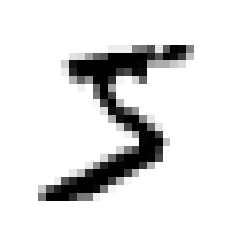

In [2]:
import numpy as  np
import matplotlib as mpl
import matplotlib.pyplot as plt

y = y.astype(np.uint8) #конвертируем массив строк y в числовой массив

some_digit = X[0]
some_digit_label = y[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
print("digit label:\n", some_digit_label)
plt.show()

Многие ML алгоритмы чувствительны к порядку данных в наборе. Например, если в процессе обучения подряд пойдут однотипные данные. Так же важно, чтобы при выполнении cross_validation в каждой выборке был аналогичный (представительный массив даннных). Набор MNIST уже подготовлен к разделению и перетосован (shaffled)

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

для упрощения проблемы выполним обучение с помощью классификатора Stochastic Gradient Descent (SGD) на упрощенном наборе данных: массив значений будет бинарным и опрделять является ли число "5" или нет. Stochastic Gradient Descent может обрабатывать большие объемы данных поскольку работает с каждым экземпляром данных отдельно, по этой же причине он хорошо в online обуччении.

In [4]:
y_train_5 = (y_train ==5 ) #бинарный вектор отвечающий на вопрос: является ли число "5"
y_test_5 = (y_test == 5) # аналогично

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=4)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=4, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [5]:
print("some_digit lable:", y[0])
print("prediction:", sgd_clf.predict([X[0]]))

some_digit lable: 5
prediction: [ True]


# Performance Measures


## Испльзование cross_validation

In [6]:
# пример разработки собственной cross validation функции

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [7]:
#Использование библиотечной cross validaion

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Полученная точность не совсем корректна, поскольку пятерок около 10% во всем массиве данных. Даже если наша модель всегда будет возвращать false, то ее точность будет 90%. Код ниже продемонстрирует это.

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5 = Never5Classifier()
cross_val_score(never5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Вычисление Confusion Matrix 

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [10]:
print(y_train_pred[:5])
print(len(y_train_pred))

[ True False False False False]
60000


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

m_conf_matrix = confusion_matrix(y_train_5, y_train_pred)
print("confusion matrix:\n", m_conf_matrix)

m_prec = precision_score(y_train_5, y_train_pred)
print("precision:", m_prec)
m_recall = recall_score(y_train_5, y_train_pred)
print("recall:", m_recall)

confusion matrix:
 [[53892   687]
 [ 1891  3530]]
precision: 0.8370879772350012
recall: 0.6511713705958311


In [12]:
#вычислим метрику f1, котороя заменяет собой обе метрики precision и recall

from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)

print("f1 score: ", f1_score(y_train_5, y_train_pred)*100)

f1 score:  73.25171197343846


## Precision/Recall Tradeoff

In [13]:
#Scikit-Learn не позволят задать порог классификации, чтобы двигать его, тем самым влияя на соотнашение 
#метрик recall & precision. Поэтому придется использовать фукнции decision_function(), которая позволит 
#этот порог реализовать. По умолчанию SGDClassifier использует порог равный "0"

y_scores = sgd_clf.decision_function([some_digit])
print("some score:", y_scores)
print("actual lable: ", some_digit_label)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("prediction with treshold:", y_some_digit_pred)

some score: [2164.22030239]
actual lable:  5
prediction with treshold: [ True]


In [14]:
#Увеличим порог и посмотрим что будет
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print("prediction with treshold:", y_some_digit_pred)

prediction with treshold: [False]


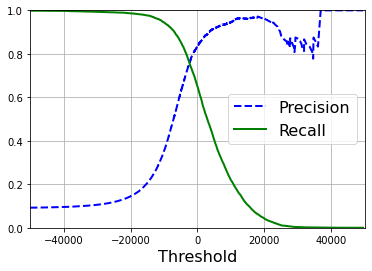

In [15]:
#Чтобы опрделить какой порог использовать необходимо получить для всех элементов массива значение dicision_function
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function", n_jobs=-1)

#используя полученные значения можно вычислить зависимость точности и отклика модели 
#для опрделения целевого значения порога
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Другой способ найти необходимое значение порога - вывести график зависимости точности от отклика модели. Из графика ниже видно, что точность падает резко, при значении порога около 0.7

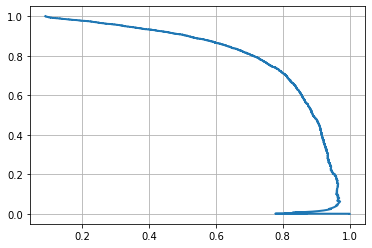

In [16]:
plt.plot(precisions, recalls, linewidth=2)
plt.grid(True)
plt.show()

Найдем целевое значение порога для точности 90%

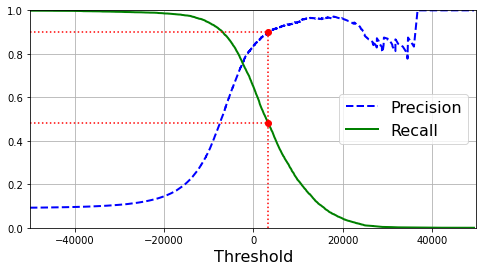

In [17]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

## ROC-анализ

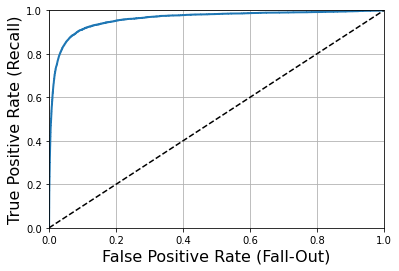

roc auc score: 0.9604938554008616


In [18]:
#описание см. в onenote
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #получение необходимых метрик для roc кривой

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()
    
from sklearn.metrics import roc_auc_score

m_roc_auc = roc_auc_score(y_train_5, y_scores)
print("roc auc score:", m_roc_auc)

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
m_roc_auc = roc_auc_score(y_train_5, y_scores)

### RandomForestClassifier

Обучим модель алгоритмом RandomForestClassifier и сравним ROC кривые и площадь с SGDClassifier.

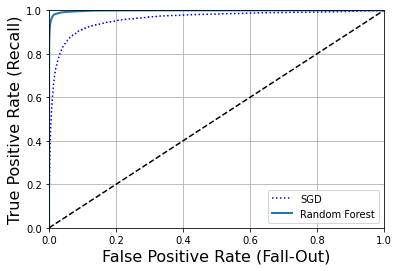

RandomForestClassifier ROC area: 0.9983436731328145


In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba", n_jobs=-1)

y_scores_forest = y_probas_forest[:, 1] #выделяем столбец с индексом 1

#данные для ROC кривой
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest) 

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
print("RandomForestClassifier ROC area:", 
      roc_auc_score(y_train_5, y_scores_forest))

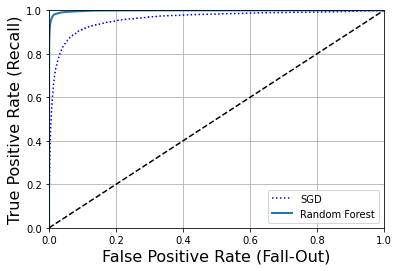

RandomForestClassifier ROC area: 0.9983436731328145


In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba", n_jobs=-1)
y_scores_forest = y_probas_forest[:, 1] #выделяем столбец с индексом 1
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest) 

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
print("RandomForestClassifier ROC area:", 
      roc_auc_score(y_train_5, y_scores_forest))

## Multiclass Classification

In [22]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
some_digit=X[0]
some_digit_lable=y[0]

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_predict = sgd_clf.predict([some_digit])
print(some_digit_scores)
print(some_digit_predict)

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
[3]


In [24]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, n_jobs=-1), n_jobs=-1)
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [25]:
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [26]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [28]:
sgd_model = SGDClassifier(random_state=42, n_jobs=-1)
forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)
ova_sgd_model = OneVsOneClassifier(SGDClassifier(random_state=42, n_jobs=-1), n_jobs=-1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

sgd_score     = cross_val_score(sgd_model, X_train_scaled, y_train, cv=3, scoring="accuracy")
forest_score  = cross_val_score(forest_model, X_train_scaled, y_train, cv=3, scoring="accuracy")
ova_sgd_score = cross_val_score(ova_sgd_model, X_train_scaled, y_train, cv=3, scoring="accuracy")

print("sgd:", sgd_score)
print("forest", forest_score)
print("ova sgd:", ova_sgd_score)

sgd: [0.8983 0.891  0.9018]
forest [0.96445 0.96255 0.96645]
ova sgd: [0.91595 0.9149  0.91845]


## Error Analysis

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


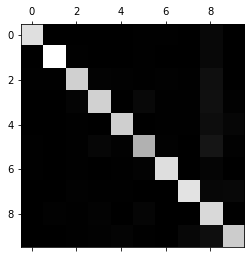

In [29]:
#вычисляем confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

[[0.         0.         0.00371433 0.00084417 0.00135067 0.00725983
  0.006078   0.001013   0.03798751 0.00016883]
 [0.         0.         0.00548799 0.00355977 0.0005933  0.00652625
  0.0005933  0.00103827 0.03144468 0.00148324]
 [0.00453172 0.00453172 0.         0.01544142 0.01225243 0.00453172
  0.01124538 0.0060423  0.06344411 0.00184626]
 [0.00358832 0.00277279 0.01908335 0.         0.00032621 0.03311042
  0.00440385 0.00652422 0.06573153 0.0119067 ]
 [0.00205409 0.00239644 0.00701814 0.00154057 0.         0.00205409
  0.00581992 0.0046217  0.05939747 0.02807258]
 [0.00498063 0.00276702 0.00553403 0.03099059 0.00977679 0.
  0.01383509 0.00258255 0.09869028 0.01106807]
 [0.00506928 0.00253464 0.00709699 0.00050693 0.00743494 0.01639067
  0.         0.00050693 0.02213586 0.00016898]
 [0.00335196 0.00159617 0.00814046 0.00478851 0.00782123 0.0019154
  0.00047885 0.         0.0311253  0.03351955]
 [0.00290549 0.01076739 0.00820373 0.01469834 0.00051273 0.02153478
  0.00427277 0.001709

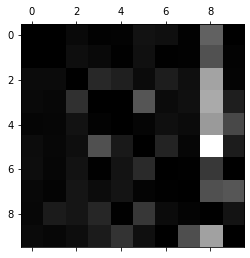

In [30]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
print(norm_conf_mx)
plt.show()

In [31]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

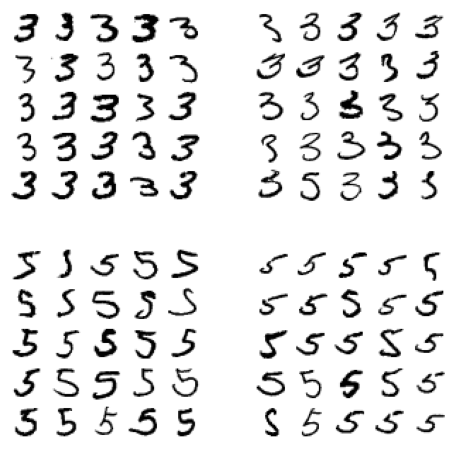

In [32]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

[[5840    1    8    2    4    9   20    1   35    3]
 [   1 6634   43   12   13    5    6   13   12    3]
 [  26   12 5749   29   32    5   20   37   42    6]
 [   7    7   93 5809    3   63    7   49   61   32]
 [  12   13   14    1 5643    0   29   14   17   99]
 [  20    9    9   65   13 5195   53    6   32   19]
 [  25   11    5    0   12   45 5805    0   15    0]
 [   4   24   58    6   37    1    0 6037   11   87]
 [   9   35   44   53   26   52   27    5 5524   76]
 [  21   10   13   76   75   15    3   58   45 5633]]


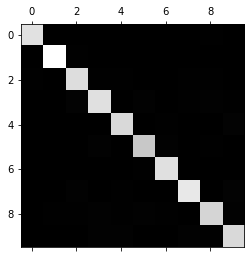

In [33]:
#analogious for the forest model
forest_y_train_pred = cross_val_predict(forest_model, X_train_scaled, y_train, cv=3)
forest_conf_mx = confusion_matrix(y_train, forest_y_train_pred)
print(forest_conf_mx)

plt.matshow(forest_conf_mx, cmap=plt.cm.gray)
plt.show()

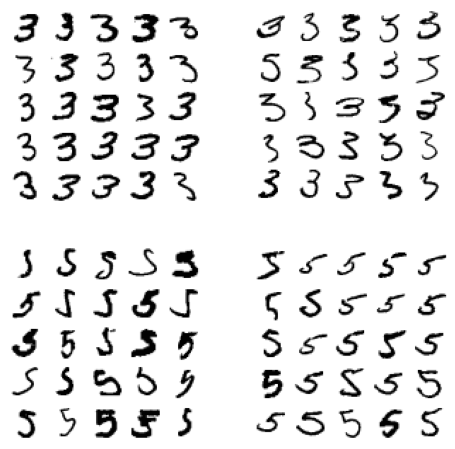

In [34]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (forest_y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (forest_y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (forest_y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (forest_y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

код ниже создает два класса: 
1) число является 7,8 или 9
2) число нечетное

Многокассовость определяется y_multilabel, где в 1й колонке реализуется 1е свойство, во 2й - второе

In [35]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

print(y_multilabel[:5])

[[False  True]
 [False False]
 [False False]
 [False  True]
 [ True  True]]


In [36]:
knn_clf.predict([some_digit])

array([[False,  True]])

## Multioutput Classification



In [37]:
#сгенерируем на базе mnist шумное изображение

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise #изображения с шумом в training set
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise #изображения с шумом в test set
y_train_mod = X_train #labels training set
y_test_mod = X_test #labels test set

In [38]:
some_img_input  = X_train_mod[0]
some_img_result = y_train_mod[0]

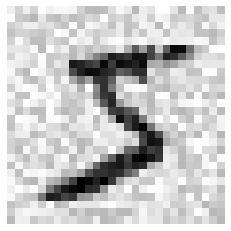

In [41]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(some_img_input)
plt.show()

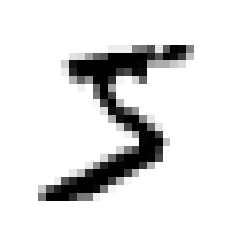

In [42]:
plot_digit(some_img_result)
plt.show()

In [45]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

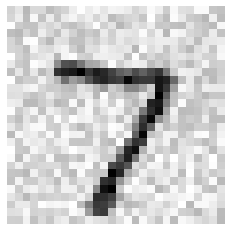

In [49]:
t1 = X_test_mod[0]
plot_digit(t1)
plt.show()

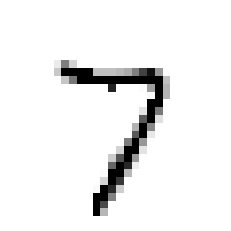

In [52]:
t1_ = knn_clf.predict([t1])
plot_digit(t1_)
plt.show()

# Задания

## Task 1

In [62]:
knn_clf = KNeighborsClassifier()

cross_result = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=3)
print("cross_val_score:", cross_result)

cross_val_score: [0.87365 0.85835 0.8689 ]


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid =[{"weights":['uniform', 'distance'], "n_neighbors":[3,4]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True, n_jobs=-1,
                          verbose=3)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

#слишком долго считает. Я подглядел в решении автора, там параметры такие:
#grid_search.best_params_
#{'n_neighbors': 4, 'weights': 'distance'}

In [73]:
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4, n_jobs=-1 )
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Task 2

In [78]:
print(type(X_train))

<class 'numpy.ndarray'>


[5 5 5 0 0 0 4 4 4 1 1 1]


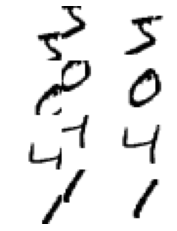

In [114]:
from scipy.ndimage.interpolation import shift

def m_shift(images, labels, k):
    new_images = list()
    for img in images:
        orig = img
        img = img.reshape((28, 28))
        im1 = shift(img, [ k,  k], cval=0, mode="constant").reshape([-1])
        im2 = shift(img, [-k, -k], cval=0, mode="constant").reshape([-1])
        new_images.extend([im1, im2, orig])
    new_labels = list()
    for l in labels:
        new_labels.extend([l, l, l])
    return np.array(new_images), np.array(new_labels, dtype=np.uint8)


x_train_shifted, y_train_shifted = m_shift(X_train[:4], y_train[:4], 8)
print(y_train_shifted)

plot_digits(x_train_shifted[:24], images_per_row=3)
plt.show()

In [115]:
x_train_shifted, y_train_shifted = m_shift(X_train, y_train, 1)

In [116]:
knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4, n_jobs=-1 )
knn_clf.fit(x_train_shifted, y_train_shifted)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [117]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.972